# Network Intrusion Detection Classifier using Support Vector Machine

Imports and Data Preparation


a) NSL-KDD

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from urllib.request import urlretrieve
from tqdm import tqdm
import os
import itertools

# URLs for NSL-KDD dataset
train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt"
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(train_file):
    print("Downloading training dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset...")
    urlretrieve(test_url, test_file)

NSL_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "class", "difficulty"
]


train_df = pd.read_csv(train_file, names=NSL_columns, header=None)
test_df = pd.read_csv(test_file, names=NSL_columns, header=None)


# Preprocessing data (Label encoding for categorical columns and convert class labels to binary (0 for normal, 1 for attack)]
df = pd.concat([train_df, test_df], axis=0)

categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

df["class"] = df["class"].apply(lambda x: 0 if x == "normal" else 1)

X = df.drop("class", axis=1).values
y = df["class"].values

X_train = X[:len(train_df)]
y_train = y[:len(train_df)]
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_test = X[len(train_df):]
y_test = y[len(train_df):]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 100778 samples
Validation set: 25195 samples
Testing set: 22544 samples


SVM Classifier Implementation

In [2]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, epochs=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = np.array(y)  # Add this line
        y_ = np.where(y <= 0, -1, 1)


        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.epochs), desc="Training Progress"):
            for idx, x_i in enumerate(X):
            # Margin condition: if the sample is correctly classified and outside the margin
                cndn = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1

                if cndn:
                # Apply L2 regularization if correctly classified and outside margin
                  self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                  # Else if it is within margin or misclassified, update both weights and bias
                  # (gradient step considers hinge loss and regularization)
                  self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                  self.b -= self.lr * y_[idx]  # Adjusting bias


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.where(approx >= 0, 1, 0)


Training and Evaluating the SVM Model

Training Progress: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

SVM Model Accuracy: 85.65%
Precision: 0.9298
Recall: 0.8091
F1-score: 0.8652
Confusion Matrix:


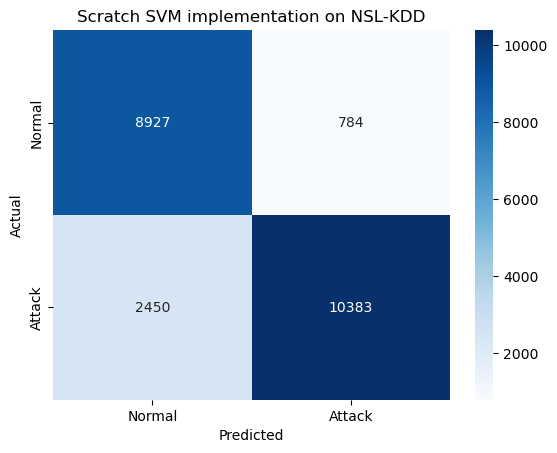

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train SVM model
svm_classifier = SVM(learning_rate=0.001, lambda_param=0.01, epochs=10)
svm_classifier.fit(X_train, y_train)

# Predict and check accuracy on test data
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test) * 100
print(f"SVM Model Accuracy: {accuracy_svm:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Print results
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
title='Scratch SVM implementation on NSL-KDD'
#plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()

In [4]:
def parameter_tuning(X_train, X_val, y_train, y_val):
    best_score = 0
    best_params = {}

    for lr in [0.1, 0.01, 0.001]:
        for lam in [0.1, 0.01, 0.001]:
            for epochs in [10, 50]:
                model = SVM(learning_rate=lr, lambda_param=lam, epochs=epochs)
                model.fit(X_train, y_train)
                preds = model.predict(X_val)
                acc = np.mean(preds == y_val)
                if acc > best_score:
                    best_score = acc
                    best_params = {
                        "learning_rate": lr,
                        "lambda_param": lam,
                        "epochs": epochs
                    }
    return best_params


# # Convert to DataFrame
# results_df = pd.DataFrame(results)

# # Plot: F1 Score Heatmap for fixed epoch
# epoch_val = 10
# subset = results_df[results_df["epochs"] == epoch_val]
# pivot_f1 = subset.pivot(index="lambda_param", columns="learning_rate", values="f1_score")

# plt.figure(figsize=(8, 6))
# sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlGnBu")
# plt.title(f"F1 Score Heatmap (Epochs = {epoch_val})")
# plt.xlabel("Learning Rate")
# plt.ylabel("Lambda (Regularization)")
# plt.show()

# # Plot: Accuracy vs Learning Rate
# plt.figure(figsize=(6,4))
# sns.lineplot(data=results_df, x="learning_rate", y="f1_score", marker="o", hue="epochs", palette="tab10")
# plt.title("f1-score vs Learning Rate")
# plt.xscale("log")
# plt.grid(True)
# plt.show()

# # Plot: Accuracy vs Lambda
# plt.figure(figsize=(6,4))
# sns.lineplot(data=results_df, x="lambda_param", y="f1_score", marker="o", hue="epochs", palette="tab10")
# plt.title("f1-score vs Lambda")
# plt.xscale("log")
# plt.grid(True)
# plt.show()

# # Plot: Accuracy vs Epochs
# plt.figure(figsize=(6,4))
# sns.lineplot(data=results_df, x="epochs", y="f1_score", marker="o", hue="learning_rate", palette="tab10")
# plt.title("f1-score vs Epochs")
# plt.grid(True)
# plt.show()

In [5]:
best = parameter_tuning(X_train,X_val,y_train,y_val)

svm_classifier = SVM(**best)
svm_classifier.fit(X_train, y_train)

# Predict and check accuracy on test data
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test) * 100

print(f"SVM Model Accuracy: {accuracy_svm:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

Training Progress: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

SVM Model Accuracy: 84.42%


Scikit learn SVM implementation

Scikit-learn SVM Accuracy: 84.71%
Precision: 0.9263
Recall: 0.7947
F1-score: 0.8555
Confusion Matrix:


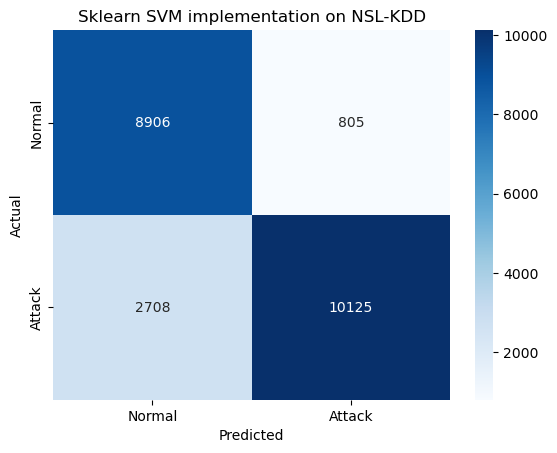

In [6]:
from sklearn.svm import SVC

svm_sklearn = SVC(kernel='linear')
svm_sklearn.fit(X_train, y_train)
y_pred_sklearn = svm_sklearn.predict(X_test)

accuracy_sklearn = np.mean(y_pred_sklearn == y_test) * 100
print(f"Scikit-learn SVM Accuracy: {accuracy_sklearn:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_sklearn)
recall_svm = recall_score(y_test, y_pred_sklearn)
f1_svm = f1_score(y_test, y_pred_sklearn)
conf_matrix_svm = confusion_matrix(y_test, y_pred_sklearn)

# Print results
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
title='Sklearn SVM implementation on NSL-KDD'
#plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()


In [7]:
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def bestparams(X_train,X_val,y_train,y_val):
# Parameter Grid
 param_grid = {
    'C': [0.1,1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
 }

 results = []
 best_score = 0
 best_accuracy = 0
 best_params = None
 best_model = None

#print("\nStarting Grid Search...\n")

# Loop through all combinations manually (like scratch model)
 for params in ParameterGrid(param_grid):
    print(f"Testing: {params}")
    model = SVC(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = np.mean(y_pred == y_val)
    f1 = f1_score(y_val, y_pred)

    results.append({
        **params,
        "accuracy": acc,
        "f1_score": f1
    })

    if acc > best_accuracy:
        best_accuracy = acc

    if f1 > best_score:
        best_score = f1
        best_params = params
        best_model = model
 return best_params

# # Convert to DataFrame
# results_df = pd.DataFrame(results)

# # Plot: F1 Score Heatmap (for kernel='rbf')
# subset = results_df[results_df["kernel"] == 'rbf']
# pivot_f1 = subset.pivot(index="C", columns="gamma", values="f1_score")

# plt.figure(figsize=(8, 6))
# sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlGnBu")
# plt.title("F1 Score Heatmap (Kernel = 'rbf')")
# plt.xlabel("Gamma")
# plt.ylabel("C")
# plt.show()

# # Plot: f1-score vs C
# plt.figure(figsize=(6, 4))
# sns.lineplot(data=results_df, x="C", y="f1_score", marker="o", hue="kernel", palette="tab10")
# plt.title("f1-score vs C")
# plt.grid(True)
# plt.show()

# # Plot: f1-score vs Kernel
# plt.figure(figsize=(6, 4))
# sns.barplot(data=results_df, x="kernel", y="f1_score", hue="C", palette="tab10")
# plt.title("f1-score vs Kernel")
# plt.grid(True)
# plt.show()

# # Plot: f1-score vs Gamma
# plt.figure(figsize=(6, 4))
# sns.barplot(data=results_df, x="gamma", y="f1_score", hue="kernel", palette="tab10")
# plt.title("f1-score vs Gamma")
# plt.grid(True)
# plt.show()

# # Evaluate best model
# y_pred_best = best_model.predict(X_test)
# precision_svm = precision_score(y_test, y_pred_best)
# recall_svm = recall_score(y_test, y_pred_best)
# f1_svm = f1_score(y_test, y_pred_best)
# conf_matrix_svm = confusion_matrix(y_test, y_pred_best)

# # Print results
# print("\nBest Model Performance on Test Set:")
# print(f"Precision: {precision_svm:.4f}")
# print(f"Recall: {recall_svm:.4f}")
# print(f"F1-score: {f1_svm:.4f}")
# print("Confusion Matrix:")

# # Plot Confusion Matrix
# sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", 
#             xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Best SVM Confusion Matrix")
# plt.show()


In [8]:
from sklearn.svm import SVC

best = bestparams(X_train, X_val, y_train, y_val)

# Use sklearn SVC with best hyperparameters
svm_classifier = SVC(**best)
svm_classifier.fit(X_train, y_train)

# Predict and check accuracy on test data
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test) * 100

print(f"SVM Model Accuracy: {accuracy_svm:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)


Testing: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Testing: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Testing: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Testing: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Model Accuracy: 85.22%


b) KDD-Cup'99

In [9]:
# (a) KDD Cup '99

url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

#defining columns 
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
df = df.drop_duplicates()  

print(df.shape)


(145586, 42)


In [10]:
print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a 
#Clearly, we can see that this daataset is very skewed and imbalanced

{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [11]:
#Preprocessing Data

# Convert categorical columns using Label Encoding (since, ML Models can only take in numerical features and not text)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Converting labels to binary, ie, 0 if normal and 1 if attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

X = df.drop("label", axis=1).values # Extracting features
y = df["label"].values #Extracting labels

# train-val-test split (60-20-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Training Progress: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

SVM Model Accuracy: 98.23%
Precision: 0.9949
Recall: 0.9604
F1-score: 0.9773
Confusion Matrix:


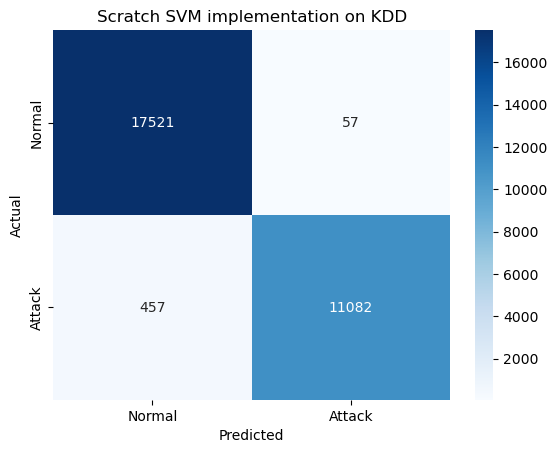

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train SVM model
svm_classifier = SVM(learning_rate=0.001, lambda_param=0.01, epochs=10)
svm_classifier.fit(X_train, y_train)

# Predict and check accuracy on test data
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test) * 100
print(f"SVM Model Accuracy: {accuracy_svm:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Print results
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
title='Scratch SVM implementation on KDD'
#plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()

In [13]:
best = parameter_tuning(X_train,X_val,y_train,y_val)

svm_classifier = SVM(**best)
svm_classifier.fit(X_train, y_train)

# Predict and check accuracy on test data
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test) * 100

print(f"SVM Model Accuracy: {accuracy_svm:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

Training Progress: 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]

SVM Model Accuracy: 98.91%


Scikit-learn SVM Accuracy: 98.99%
Precision: 0.9885
Recall: 0.9859
F1-score: 0.9872
Confusion Matrix:


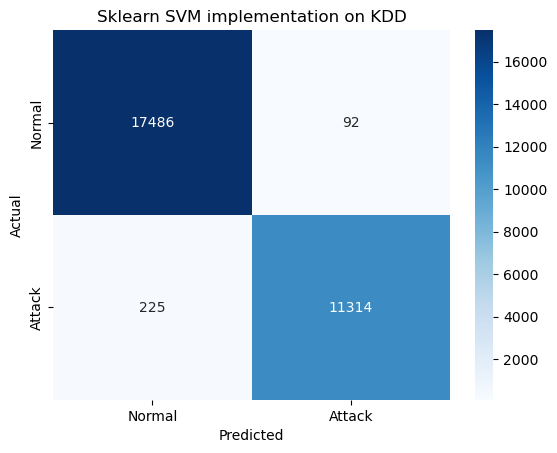

In [14]:
from sklearn.svm import SVC

svm_sklearn = SVC(kernel='linear')
svm_sklearn.fit(X_train, y_train)
y_pred_sklearn = svm_sklearn.predict(X_test)

accuracy_sklearn = np.mean(y_pred_sklearn == y_test) * 100
print(f"Scikit-learn SVM Accuracy: {accuracy_sklearn:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_sklearn)
recall_svm = recall_score(y_test, y_pred_sklearn)
f1_svm = f1_score(y_test, y_pred_sklearn)
conf_matrix_svm = confusion_matrix(y_test, y_pred_sklearn)

# Print results
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
title='Sklearn SVM implementation on KDD'
#plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()


In [15]:
from sklearn.svm import SVC

best = bestparams(X_train, X_val, y_train, y_val)

# Use sklearn SVC with best hyperparameters
svm_classifier = SVC(**best)
svm_classifier.fit(X_train, y_train)

# Predict and check accuracy on test data
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test) * 100

print(f"SVM Model Accuracy: {accuracy_svm:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print(f"F1-score : {f1_svm}")

Testing: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Testing: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Testing: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Testing: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Model Accuracy: 99.74%
F1-score : 0.9967042497831743
